# **---Bagian Model BERTopic----**

In [1]:
# prompt: download semua module yang di butuhkan pada cell diatas

!pip install transformers
!pip install torch
!pip install umap-learn
!pip install hdbscan
!pip install bertopic
!pip install gspread
!pip install google-auth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

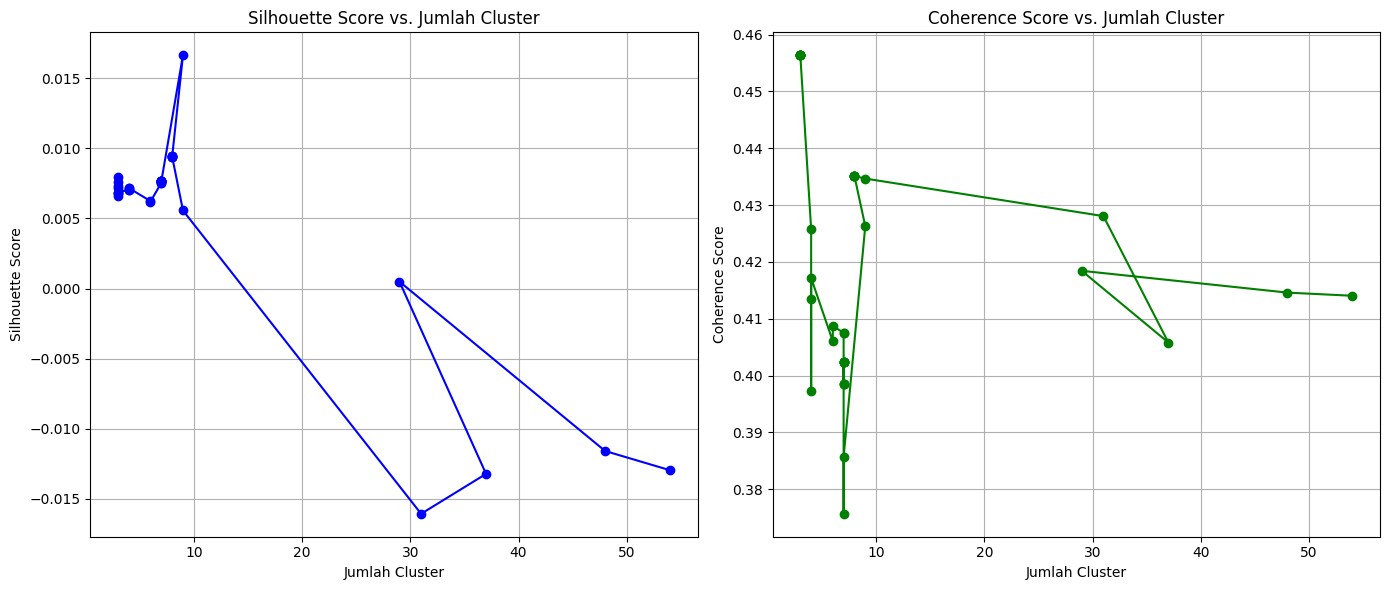

Jumlah cluster optimal berdasarkan Silhouette Score: 9
Silhouette Score optimal: 0.016644494608044624
Jumlah cluster optimal berdasarkan Coherence Score: 3
Coherence Score optimal: 0.4563562882566335


In [ ]:
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
from hdbscan import HDBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Membaca file CSV
file_path = "tahap_7.csv"  # Ganti dengan path file CSV Anda
data = pd.read_csv(file_path)

# Pastikan kolom teks tidak ada nilai NaN dan semua data berupa string
data['cleaned_text'] = data['cleaned_text'].fillna("").astype(str)

# Mengambil kolom teks (misalnya, kolom 'cleaned_text')
documents = data['cleaned_text'].tolist()

# Load IndoBERT model
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Sesuaikan UMAP
umap_model = UMAP(n_neighbors=5, n_components=2, random_state=42)

# Mengatur HDBSCAN untuk menentukan jumlah cluster
hdbscan_model = HDBSCAN(min_cluster_size=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Fungsi untuk menghitung silhouette score dan coherence score untuk berbagai nilai min_cluster_size
def calculate_scores(min_cluster_sizes, documents, tokenizer, model, umap_model, hdbscan_model):
    silhouette_scores = []
    coherence_scores = []
    cluster_counts = []

    for min_cluster_size in min_cluster_sizes:
        # Mengatur ulang model HDBSCAN dengan min_cluster_size yang berbeda
        hdbscan_model.min_cluster_size = min_cluster_size
        topic_model = BERTopic(embedding_model=(tokenizer, model),
                               hdbscan_model=hdbscan_model,
                               umap_model=umap_model,
                               language="multilingual",
                               calculate_probabilities=True,
                               verbose=False)

        # Fit model ke dokumen
        topics, _ = topic_model.fit_transform(documents)

        # Mengambil label cluster yang dihasilkan
        labels = topics

        # Mengabaikan noise (label -1), jika ada
        if len(set(labels)) > 1:
            # Get embeddings directly using the embedding_model
            embeddings = topic_model.embedding_model.embed(documents)  # change this line to get the embeddings

            # Menghitung silhouette score untuk cluster selain noise (-1)
            score = silhouette_score(embeddings, labels)
            silhouette_scores.append(score)

            # Menghitung coherence score untuk cluster selain noise (-1)
            tokenized_documents = [doc.split() for doc in documents]
            dictionary = Dictionary(tokenized_documents)
            corpus = [dictionary.doc2bow(text) for text in tokenized_documents]

            topics_keywords = topic_model.get_topics()
            topics_list = [[word for word, _ in topics_keywords[i]] for i in topics_keywords.keys() if i != -1]

            coherence_model = CoherenceModel(topics=topics_list, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append(coherence_score)

            # Menghitung jumlah cluster valid
            cluster_counts.append(len(set(labels)) - (1 if -1 in labels else 0))
        else:
            silhouette_scores.append(-1)  # Jika hanya ada noise
            coherence_scores.append(-1)   # Jika hanya ada noise
            cluster_counts.append(0)

    return silhouette_scores, coherence_scores, cluster_counts

# Tentukan rentang min_cluster_size untuk pengujian
min_cluster_sizes = range(10, 50)  # Uji dengan ukuran cluster minimum antara 3 dan 10

# Hitung silhouette score dan coherence score untuk berbagai min_cluster_size
silhouette_scores, coherence_scores, cluster_counts = calculate_scores(min_cluster_sizes, documents, tokenizer, model, umap_model, hdbscan_model)

# Plot hasil silhouette score dan coherence score terhadap jumlah cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Silhouette Score
ax1.plot(cluster_counts, silhouette_scores, marker='o', color='b')
ax1.set_title('Silhouette Score vs. Jumlah Cluster')
ax1.set_xlabel('Jumlah Cluster')
ax1.set_ylabel('Silhouette Score')
ax1.grid(True)

# Plot Coherence Score
ax2.plot(cluster_counts, coherence_scores, marker='o', color='g')
ax2.set_title('Coherence Score vs. Jumlah Cluster')
ax2.set_xlabel('Jumlah Cluster')
ax2.set_ylabel('Coherence Score')
ax2.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

# Menampilkan hasil terbaik
best_silhouette_score_idx = np.argmax(silhouette_scores)
best_coherence_score_idx = np.argmax(coherence_scores)

print(f"Jumlah cluster optimal berdasarkan Silhouette Score: {cluster_counts[best_silhouette_score_idx]}")
print(f"Silhouette Score optimal: {silhouette_scores[best_silhouette_score_idx]}")

print(f"Jumlah cluster optimal berdasarkan Coherence Score: {cluster_counts[best_coherence_score_idx]}")
print(f"Coherence Score optimal: {coherence_scores[best_coherence_score_idx]}")


In [ ]:
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
from hdbscan import HDBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Membaca file CSV
file_path = "tahap_7.csv"  # Ganti dengan path file CSV Anda
data = pd.read_csv(file_path)
# Pastikan kolom teks tidak ada nilai NaN dan semua data berupa string
data['cleaned_text'] = data['cleaned_text'].fillna("").astype(str)
# Mengambil kolom teks (misalnya, kolom 'text')
documents = data['cleaned_text'].tolist()


# Sesuaikan UMAP
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)
umap_model = UMAP(n_neighbors=5, n_components=2, random_state=42)
umap_data = umap_model.fit_transform(X)


# Mengatur HDBSCAN untuk menentukan jumlah cluster
hdbscan_model = HDBSCAN(min_cluster_size=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Load IndoBERT model
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Buat model BERTopic
topic_model = BERTopic(embedding_model=(tokenizer, model),
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       language="multilingual",
                       calculate_probabilities=True,
                       verbose=True)

# Fit model ke dokumen
topics, probabilities = topic_model.fit_transform(documents)

# Visualisasi topik
topic_model.visualize_topics()



2025-02-25 19:04:39,846 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

2025-02-25 19:05:22,790 - BERTopic - Embedding - Completed ✓
2025-02-25 19:05:22,792 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-25 19:05:38,666 - BERTopic - Dimensionality - Completed ✓
2025-02-25 19:05:38,671 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-25 19:05:39,544 - BERTopic - Cluster - Completed ✓
2025-02-25 19:05:39,553 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-25 19:05:39,816 - BERTopic - Representation - Completed ✓


In [ ]:

# Print the number of topics
print(len(topic_model.get_topic_info()))

55


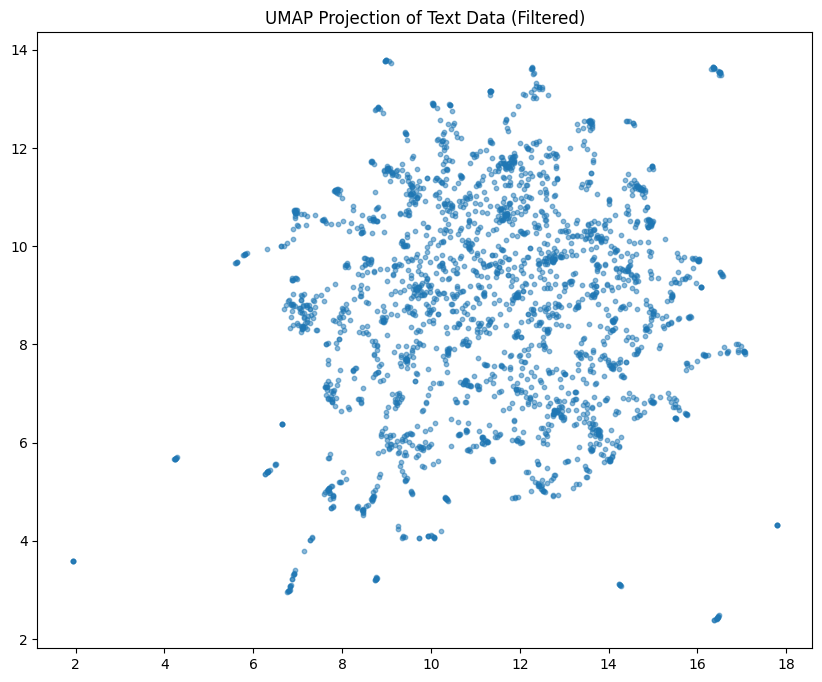

In [ ]:
# Filter data UMAP untuk menghilangkan nilai dibawah 0
umap_data_filtered = umap_data[np.all(umap_data >= 0, axis=1)]

# Visualisasi hasil UMAP
plt.figure(figsize=(10, 8))
plt.scatter(umap_data_filtered[:, 0], umap_data_filtered[:, 1], s=10, alpha=0.5)
plt.title('UMAP Projection of Text Data (Filtered)')
plt.show()


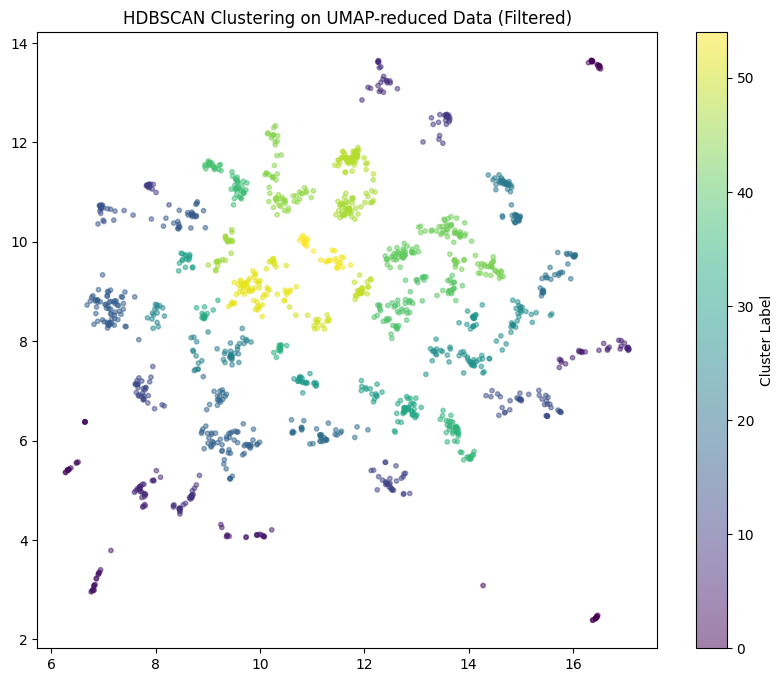

In [ ]:
# Visualisasi kluster HDBSCAN
cluster_labels = hdbscan_model.fit_predict(umap_data_filtered)

# Filter data dan cluster labels untuk menghilangkan nilai negatif
umap_data_filtered = umap_data_filtered[cluster_labels != -1]  # Menghapus data dengan cluster label -1 (noise)
cluster_labels_filtered = cluster_labels[cluster_labels != -1]

plt.figure(figsize=(10, 8))
plt.scatter(umap_data_filtered[:, 0], umap_data_filtered[:, 1], c=cluster_labels_filtered, cmap='viridis', s=10, alpha=0.5)
plt.title('HDBSCAN Clustering on UMAP-reduced Data (Filtered)')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
# prompt: buatakan gambaran visual hasil HDBSCAN

# Visualisasi distribusi topik
topic_model.visualize_distribution(probabilities[-1])

# Visualisasi hierarki cluster
topic_model.visualize_hierarchy()

# Visualisasi interaksi antar topik
topic_model.visualize_heatmap()


In [ ]:
from sklearn.metrics import silhouette_score

# Access the embeddings from the SentenceTransformer model
embeddings = topic_model.embedding_model.embed(documents)

# Menghitung silhouette score
silhouette_avg = silhouette_score(embeddings, topics)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.012964856810867786


In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Memproses dokumen untuk Gensim
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(text) for text in tokenized_documents]

# Mengambil kata kunci dari setiap topik
topics_keywords = topic_model.get_topics()
topics_list = [[word for word, _ in topics_keywords[i]] for i in topics_keywords.keys() if i != -1]

# Coherence model
coherence_model = CoherenceModel(topics=topics_list, texts=tokenized_documents, dictionary=dictionary, coherence='c_v') #Gunakan metrik seperti UMass, C_v, atau C_np.
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.41403090873699305


In [ ]:
# 1. Informasi Dasar Topik
topic_info = topic_model.get_topic_info()
print("Informasi Dasar Topik:")
print(topic_info)


Informasi Dasar Topik:
    Topic  Count                                     Name  \
0      -1    896       -1_jokowi_korupsi_koruptor_prabowo   
1       0    156             0_fufufafa_bego_kontol_kafir   
2       1     88                   1_pssi_ajg_bonus_tolol   
3       2     71             2_presiden_jokowi_beliau_utk   
4       3     67              3_penista_agama_rt_terdakwa   
5       4     62            4_jaksa_agung_langkah_prabowo   
6       5     54         5_wilayah_kejaksaan_negeri_bebas   
7       6     50          6_data_kebocoran_kominfo_penipu   
8       7     47                   7_bodoh_gay_syari_agus   
9       8     42                   8_api_pengen_ko_pantai   
10      9     40          9_koruptor_level_budaya_korupsi   
11     10     38                10_jokowi_dek_jilat_sehat   
12     11     38                11_buzzer_serang_lo_nggak   
13     12     36                  12_islam_ahok_agama_kau   
14     13     35        13_negara_indonesia_sesat_penjara   
1

In [ ]:
# 5. Frekuensi Kemunculan Topik
topic_frequency = topic_model.get_topic_freq()
print("\nFrekuensi Kemunculan Topik:")
print(topic_frequency)



Frekuensi Kemunculan Topik:
    Topic  Count
0      -1    896
16      0    156
23      1     88
19      2     71
28      3     67
34      4     62
25      5     54
7       6     50
4       7     47
11      8     42
31      9     40
33     10     38
21     11     38
13     12     36
1      13     35
51     14     33
40     15     32
14     16     31
5      17     31
27     18     29
37     19     28
6      20     27
9      21     26
18     22     25
12     23     24
47     24     23
44     25     23
8      26     22
35     27     18
20     28     18
36     29     17
38     30     17
54     31     16
22     32     16
39     33     16
32     34     15
17     35     15
29     36     15
43     37     14
10     38     14
49     39     14
15     40     14
46     41     14
30     42     13
3      43     13
24     44     13
26     45     13
45     46     12
48     47     12
50     48     12
52     49     12
42     50     12
41     51     11
2      52     11
53     53     11


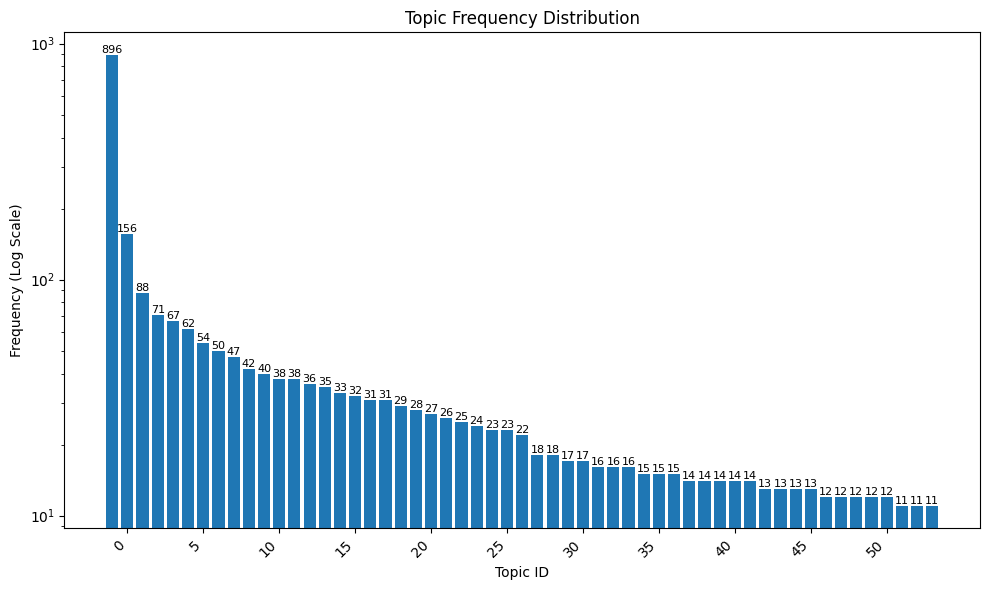

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the bar chart with log scale for better readability
plt.figure(figsize=(10, 6))
bars = plt.bar(topic_frequency['Topic'], topic_frequency['Count'], log=True)

# Add titles and labels
plt.xlabel("Topic ID")
plt.ylabel("Frequency (Log Scale)")
plt.title("Topic Frequency Distribution")

# Add annotations directly above each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar (i.e., frequency)
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(int(yval)), ha='center', va='bottom', fontsize=8)

# Adjust x-axis ticks to make them more readable
plt.xticks(np.arange(0, max(topic_frequency['Topic']), step=5), rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# 2. Topik Terpilih (Representasi Kata Kunci untuk Topik Tertentu)
all_topics = topic_model.get_topics()
print("\nSemua Kata Kunci dari Semua Topik:")
for topic, keywords in all_topics.items():
    print(f"Topik {topic}: {keywords}")


Semua Kata Kunci dari Semua Topik:
Topik -1: [('jokowi', 0.014239481467609193), ('korupsi', 0.013410283227102714), ('koruptor', 0.011097154322010484), ('prabowo', 0.010624629494502272), ('kafir', 0.00858449931607808), ('lu', 0.00833483097033594), ('rakyat', 0.00811356035036014), ('indonesia', 0.007971217186318736), ('tolol', 0.007904731139659038), ('negara', 0.00786049294992742)]
Topik 0: [('fufufafa', 0.1468138157371778), ('bego', 0.05349019158812587), ('kontol', 0.05261424993084393), ('kafir', 0.03980799835291085), ('dungu', 0.03332235828953449), ('mulyono', 0.02984945184983615), ('ganyang', 0.024146018254327616), ('anjing', 0.01968183273016746), ('tolol', 0.01948468026345833), ('bajingan', 0.016086167896266754)]
Topik 1: [('pssi', 0.12513827180883597), ('ajg', 0.078103687645484), ('bonus', 0.059583532382803304), ('tolol', 0.0584317725843596), ('pildun', 0.049595740401720025), ('exco', 0.0445379740791304), ('momentum', 0.04228776544953049), ('klub', 0.04102260340454141), ('liga', 0.

In [ ]:
# 3. Dokumen Perwakilan untuk Setiap Topik
representative_docs = topic_model.get_representative_docs()
print("\nDokumen Perwakilan untuk Setiap Topik:")
for topic, docs in representative_docs.items():
    print(f"Topik {topic}: {docs}")


Dokumen Perwakilan untuk Setiap Topik:
Topik -1: ['hello guys butuh app premium ready full garansi order wa reply netflix canva youtube capcut k vidio bstation viu wetv iqiyi chatgpt loklok am amazon prime picsart coin line rep q tag jual beli need tolol pssi anak', 'hello guys butuh app premium ready full garansi order wa reply netflix canva youtube capcut k vidio bstation viu wetv iqiyi chatgpt loklok am amazon prime picsart coin line rep dll q jual beli need pssi tolol anak', 'hello guys butuh app premium ready full garansi order wa reply netflix canva youtube capcut k vidio bstation viu wetv iqiyi chatgpt loklok am amazon prime picsart coin line rep dll q jual beli need tolol pssi anak']
Topik 0: ['emang kontol fufufafa', 'f fufufafa dungu', 'tolol fufufafa kafir']
Topik 1: ['promo royalkasino link bonus new member bonus depo harian bonus cashback slot bonus ampas scatter mahjong bonus event parlay promo super reward royalkasino tag ri jumat siang smtown pssi', 'promo royalkasino 

In [ ]:
topik=3
topic_model.get_topic(topic=topik)

[('penista', 0.20706878080890329),
 ('agama', 0.14809103205646662),
 ('rt', 0.07761332122497698),
 ('terdakwa', 0.04427233959313654),
 ('si', 0.042910739632194925),
 ('ahok', 0.03970217296466212),
 ('pendukung', 0.0356230298447515),
 ('santri', 0.02891744606244143),
 ('islam', 0.026616678259196686),
 ('cina', 0.02377259940485754)]

In [ ]:
topic_model.get_representative_docs(topik)

['rt penjarakan penista agama turun',
 'rt tolol bela penista agama tersangka',
 'emang ahok orang penista agama']

In [ ]:
# 8. Visualisasi Topik
print("\nMembuka Visualisasi Interaktif Topik:")
topic_model.visualize_topics()


Membuka Visualisasi Interaktif Topik:


In [ ]:

dimensional_map = topic_model.visualize_barchart()
print("\nVisualisasi Bar Chart Topik Teratas:")
dimensional_map.show()


Visualisasi Bar Chart Topik Teratas:


In [ ]:
topic_frequency.to_csv("total_topic_frequency.csv", index=False)

In [ ]:
# Menambahkan hasil topik ke dalam dataframe
data['topic'] = topics

# Menyimpan hasil ke file CSV baru
output_file = "Hasil_1.csv"  # Nama file output
data.to_csv(output_file, index=False)

print(f"Hasil clustering telah disimpan dalam {output_file}")


Hasil clustering telah disimpan dalam Hasil_1.csv


In [ ]:
import pandas as pd

# Anggap Anda telah memiliki objek model BERTopik yang telah dilatih, misalnya 'topic_model'
# Dapatkan jumlah topik yang dihasilkan
topics = topic_model.get_topics()  # Misalnya, ini adalah hasil topik dari model BERTopik
n_topics = len(topics)  # Jumlah topik yang dihasilkan oleh model

# Menyusun representasi dokumen untuk setiap topik
representative_docs = []
for topic_id in range(-1, n_topics-1):  # Perulangan dimulai dari -1
    # Ambil dokumen representatif untuk setiap topik
    docs = topic_model.get_representative_docs(topic_id)  # Mendapatkan dokumen representatif untuk topik tertentu
    representative_docs.append(' '.join(docs))  # Gabungkan dokumen dalam satu string

# Membuat DataFrame
df = pd.DataFrame({
    'topik': [f"Topik {i}" for i in range(-1, n_topics-1)],  # Nama topik otomatis, mulai dari -1
    'Representative_Docs': representative_docs
})

# Menyimpan ke file CSV
df.to_csv('representative_docs.csv', index=False)

print(f"File CSV berhasil dibuat dengan {n_topics} topik, dimulai dari topik -1.")


File CSV berhasil dibuat dengan 55 topik, dimulai dari topik -1.


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

# **---Bagian Metrix Evaluasi----**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_topic_diversity(topic_model):
    # Ambil kata-kata dari setiap topik
    topic_words = topic_model.get_topic_info()
    topic_words = topic_words[topic_words['Topic'] != -1]  # Menghindari noise (topic -1)

    diversity_scores = []
    for topic in topic_words['Topic'].unique():
        # Ambil daftar kata untuk topik ini
        words = [word for word, _ in topic_model.get_topic(topic)]

        # Membangun vektor kata menggunakan TfidfVectorizer
        word_vectors = vectorizer.transform(words).toarray()

        # Hitung Cosine Similarity antar kata
        cosine_sim = cosine_similarity(word_vectors)
        # Nilai diversity dihitung sebagai rata-rata jarak antar kata
        diversity_score = 1 - np.mean(cosine_sim)  # Higher diversity means lower similarity
        diversity_scores.append(diversity_score)

    return np.mean(diversity_scores)

diversity = calculate_topic_diversity(topic_model)
print(f"Topic Diversity Score: {diversity}")


Topic Diversity Score: 0.9009259259259258


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

# **---Bagian Model Pengurangan Noise----**

In [ ]:
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
from hdbscan import HDBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Membaca file CSV
file_path = "Hasil_1.csv"  # Ganti dengan path file CSV Anda
data = pd.read_csv(file_path)

# Memfilter data berdasarkan nilai label yang bernilai 0
data_filtered = data[data['topic'] == 0]

# Pastikan kolom teks tidak ada nilai NaN dan semua data berupa string
data_filtered['cleaned_text'] = data_filtered['cleaned_text'].fillna("").astype(str)

# Mengambil kolom teks (misalnya, kolom 'text')
documents = data_filtered['cleaned_text'].tolist()

# Load IndoBERT model
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Sesuaikan UMAP
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)
umap_model = UMAP(n_neighbors=7, n_components=5, random_state=42)
umap_data = umap_model.fit_transform(X)

# Mengatur HDBSCAN untuk menentukan jumlah cluster
hdbscan_model = HDBSCAN(min_cluster_size=20,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Buat model BERTopic
topic_model = BERTopic(embedding_model=(tokenizer, model),
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       language="multilingual",
                       calculate_probabilities=True,
                       verbose=True)

# Fit model ke dokumen
topics, probabilities = topic_model.fit_transform(documents)

# Visualisasi topik
topic_model.visualize_topics()


2025-02-17 20:37:19,252 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

2025-02-17 20:38:01,579 - BERTopic - Embedding - Completed ✓
2025-02-17 20:38:01,581 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-17 20:38:09,578 - BERTopic - Dimensionality - Completed ✓
2025-02-17 20:38:09,580 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-17 20:38:09,768 - BERTopic - Cluster - Completed ✓
2025-02-17 20:38:09,773 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-17 20:38:09,839 - BERTopic - Representation - Completed ✓


In [ ]:
# 1. Informasi Dasar Topik
topic_info = topic_model.get_topic_info()
print("Informasi Dasar Topik:")
print(topic_info)


Informasi Dasar Topik:
    Topic  Count                                   Name  \
0      -1    852      -1_korupsi_jokowi_koruptor_rakyat   
1       0    270       0_korupsi_koruptor_jaksa_prabowo   
2       1    195              1_pssi_ajg_tolol_koruptor   
3       2    148           2_fufufafa_bego_kontol_kafir   
4       3    106               3_jokowi_kafir_sesat_pir   
5       4     99                4_orang_artis_si_jokowi   
6       5     95      5_presiden_jokowi_prabowo_korupsi   
7       6     61          6_negara_politik_korupsi_uang   
8       7     50      7_pengen_keluarga_agama_perbedaan   
9       8     48              8_agus_goblok_tolol_sedih   
10      9     32              9_anjing_china_babi_dhani   
11     10     31                10_fans_pssi_netizen_gk   
12     11     29             11_yahudi_kayak_hahaha_loh   
13     12     20  12_indonesia_singapura_jokowi_prabowo   

                                       Representation  \
0   [korupsi, jokowi, koruptor, ra

In [ ]:
# 5. Frekuensi Kemunculan Topik
topic_frequency = topic_model.get_topic_freq()
print("\nFrekuensi Kemunculan Topik:")
print(topic_frequency)



Frekuensi Kemunculan Topik:
    Topic  Count
2      -1    852
12      0    270
13      1    195
10      2    148
8       3    106
7       4     99
11      5     95
6       6     61
5       7     50
0       8     48
3       9     32
4      10     31
9      11     29
1      12     20


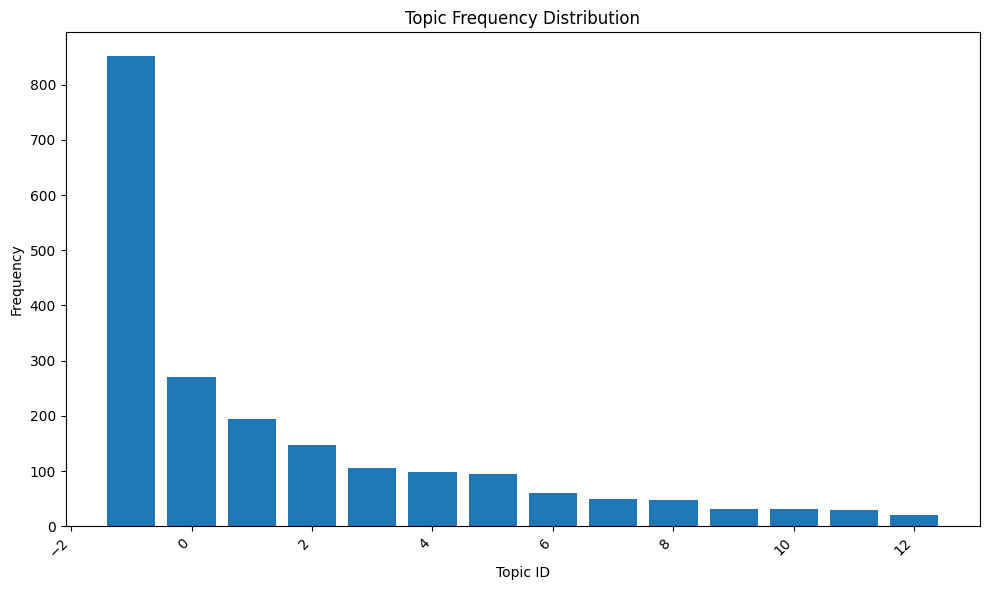

In [ ]:
# prompt: buat frekwensi kemunculan topik dalam bnetuk barchart

import matplotlib.pyplot as plt

# Assuming 'topic_frequency' is the DataFrame from topic_model.get_topic_freq()
# topic_frequency = topic_model.get_topic_freq()

# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(topic_frequency['Topic'], topic_frequency['Count'])
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.title("Topic Frequency Distribution")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# 8. Visualisasi Topik
print("\nMembuka Visualisasi Interaktif Topik:")
topic_model.visualize_topics()


Membuka Visualisasi Interaktif Topik:


In [ ]:
# Menambahkan label topik ke DataFrame
data_filtered['topic'] = topics  # Menambahkan kolom 'topic' yang berisi label topik untuk setiap dokumen

# Menyimpan Data ke File CSV
output_file_path = "Hasil_2.csv"  # Ganti dengan nama file output yang diinginkan
data_filtered.to_csv(output_file_path, index=False)

# Opsional: Jika ingin melihat hasilnya
print(data_filtered[['cleaned_text', 'topic']].head())

                                        cleaned_text  topic
0              agus dungu berenang gaya kayu ngapung      8
1  kesini emosi lihat sistem penegakan hukum indo...     12
2                                         agus dungu      8
3                           sih kayaknya agus goblok      8
5                                  agus buntung wkwk     -1


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

# **---Bagian Model Pengurangan Noise----**

In [ ]:
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
from hdbscan import HDBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Membaca file CSV
file_path = "Hasil_2.csv"  # Ganti dengan path file CSV Anda
data = pd.read_csv(file_path)

# Memfilter data berdasarkan nilai label yang bernilai 0
data_filtered = data[data['topic'] == -1]

# Pastikan kolom teks tidak ada nilai NaN dan semua data berupa string
data_filtered['cleaned_text'] = data_filtered['cleaned_text'].fillna("").astype(str)

# Mengambil kolom teks (misalnya, kolom 'text')
documents = data_filtered['cleaned_text'].tolist()

# Load IndoBERT model
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = AutoModel.from_pretrained("indolem/indobert-base-uncased")

# Sesuaikan UMAP
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)
umap_model = UMAP(n_neighbors=2, n_components=5, random_state=42)
umap_data = umap_model.fit_transform(X)

# Mengatur HDBSCAN untuk menentukan jumlah cluster
hdbscan_model = HDBSCAN(min_cluster_size=15,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Buat model BERTopic
topic_model = BERTopic(embedding_model=(tokenizer, model),
                       hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       language="multilingual",
                       calculate_probabilities=True,
                       verbose=True)

# Fit model ke dokumen
topics, probabilities = topic_model.fit_transform(documents)

# Visualisasi topik
topic_model.visualize_topics()


2025-02-17 20:52:04,782 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2025-02-17 20:52:35,691 - BERTopic - Embedding - Completed ✓
2025-02-17 20:52:35,692 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-17 20:52:37,029 - BERTopic - Dimensionality - Completed ✓
2025-02-17 20:52:37,030 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-17 20:52:37,118 - BERTopic - Cluster - Completed ✓
2025-02-17 20:52:37,124 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-17 20:52:37,173 - BERTopic - Representation - Completed ✓


In [ ]:
# 1. Informasi Dasar Topik
topic_info = topic_model.get_topic_info()
print("Informasi Dasar Topik:")
print(topic_info)


Informasi Dasar Topik:
    Topic  Count                                  Name  \
0      -1    402          -1_pssi_korupsi_jokowi_tolol   
1       0     40         0_negara_harvey_moeis_korupsi   
2       1     35         1_rakyat_indonesia_negara_gas   
3       2     32           2_media_ngomong_survey_kena   
4       3     30    3_orang_pemerintah_pemilih_prabowo   
5       4     29        4_wilayah_negeri_kejaksaan_wbk   
6       5     29        5_vonis_ringan_ratusan_triliun   
7       6     27                  6_laut_gag_goblok_lo   
8       7     22             7_kontol_agus_wasit_silvy   
9       8     22       8_jaksa_prabowo_agung_perubahan   
10      9     21       9_anjing_percaya_orang_fufufafa   
11     10     19  10_bersihkan_samasama_partai_petugas   
12     11     19         11_adili_gue_sebentar_korupsi   
13     12     19              12_penjara_jawa_dana_doi   
14     13     19           13_kafir_ahok_bohong_rakyat   
15     14     19       14_sesat_kebijakan_pesat_p

In [ ]:
# 5. Frekuensi Kemunculan Topik
topic_frequency = topic_model.get_topic_freq()
print("\nFrekuensi Kemunculan Topik:")
print(topic_frequency)



Frekuensi Kemunculan Topik:
    Topic  Count
2      -1    402
13      0     40
14      1     35
9       2     32
8       3     30
10      4     29
19      5     29
7       6     27
3       7     22
15      8     22
0       9     21
5      10     19
11     11     19
12     12     19
17     13     19
18     14     19
16     15     18
1      16     17
4      17     17
6      18     16


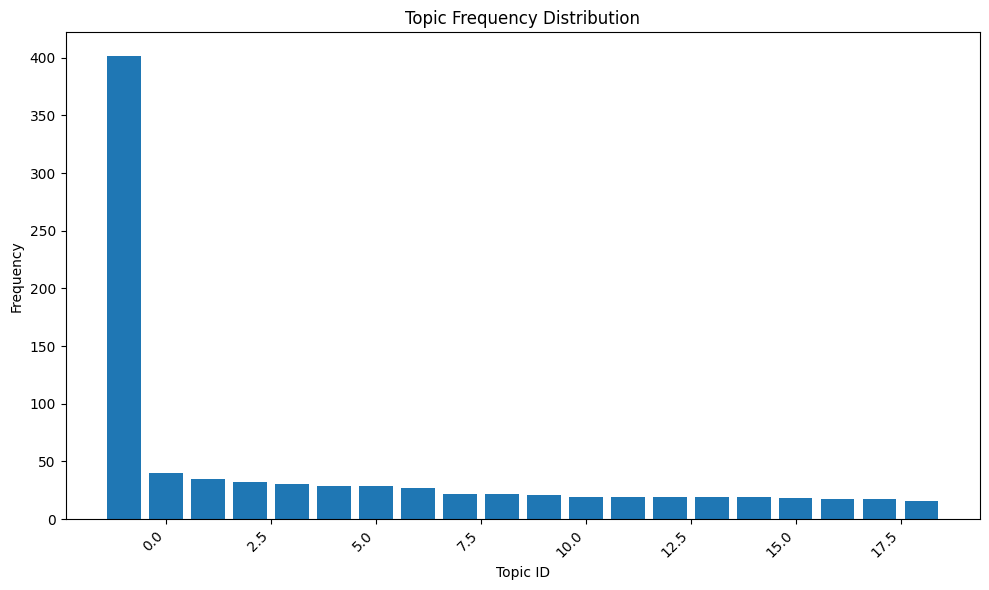

In [ ]:
# prompt: buat frekwensi kemunculan topik dalam bnetuk barchart

import matplotlib.pyplot as plt

# Assuming 'topic_frequency' is the DataFrame from topic_model.get_topic_freq()
# topic_frequency = topic_model.get_topic_freq()

# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(topic_frequency['Topic'], topic_frequency['Count'])
plt.xlabel("Topic ID")
plt.ylabel("Frequency")
plt.title("Topic Frequency Distribution")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# 8. Visualisasi Topik
print("\nMembuka Visualisasi Interaktif Topik:")
topic_model.visualize_topics()


Membuka Visualisasi Interaktif Topik:


In [ ]:
# Menambahkan label topik ke DataFrame
data_filtered['topic'] = topics  # Menambahkan kolom 'topic' yang berisi label topik untuk setiap dokumen

# Menyimpan Data ke File CSV
output_file_path = "Hasil_3.csv"  # Ganti dengan nama file output yang diinginkan
data_filtered.to_csv(output_file_path, index=False)

# Opsional: Jika ingin melihat hasilnya
print(data_filtered[['cleaned_text', 'topic']].head())

                                         cleaned_text  topic
4                                   agus buntung wkwk      9
6   kayaknya agus bodoh pengen coli cari mangsa al...     16
7       wkwkwkwk agus buntung menginspirasi drpd siti      9
9   jadiin babi guling ajangga tau terima kasih nu...     -1
12                                         agus jelek     -1


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
import pandas as pd

# Nama file CSV
file1 = "Hasil_1.csv"  # Ganti dengan nama file yang sesuai
file2 = "Hasil_2.csv"
output_file = "hasil_gabungan_1.csv"

# Tentukan label yang ingin dihapus dari file1
label_dihapus = [0]  # Ganti dengan label yang ingin dihapus (bisa lebih dari satu)

# Membaca file CSV
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Hapus data di file1 yang memiliki label tertentu
df1 = df1[~df1['topic'].isin(label_dihapus)]

# Gabungkan kedua data setelah penghapusan
df_combined = pd.concat([df1, df2], ignore_index=True)

# Simpan hasil
df_combined.to_csv(output_file, index=False)

print(f"File hasil gabungan telah disimpan sebagai {output_file}")


File hasil gabungan telah disimpan sebagai hasil_gabungan_1.csv


In [ ]:
import pandas as pd

# Nama file CSV
file1 = "hasil_gabungan_1.csv"  # Ganti dengan nama file yang sesuai
file2 = "Hasil_3.csv"
output_file = "hasil_gabungan_2.csv"

# Tentukan label yang ingin dihapus dari file1
label_dihapus = [-1]  # Ganti dengan label yang ingin dihapus (bisa lebih dari satu)

# Membaca file CSV
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Hapus data di file1 yang memiliki label tertentu
df1 = df1[~df1['topic'].isin(label_dihapus)]

# Gabungkan kedua data setelah penghapusan
df_combined = pd.concat([df1, df2], ignore_index=True)

# Simpan hasil
df_combined.to_csv(output_file, index=False)

print(f"File hasil gabungan telah disimpan sebagai {output_file}")


File hasil gabungan telah disimpan sebagai hasil_gabungan_2.csv


In [ ]:
import pandas as pd

# Nama file CSV
file1 = "hasil_gabungan_2.csv"  # Ganti dengan nama file yang sebenarnya
file2 = "tahap_7.csv"

# Membaca file CSV
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Menghitung jumlah data
total_file1 = len(df1)
total_file2 = len(df2)
total_semua = total_file1 + total_file2

# Menampilkan hasil
print(f"Total data di {file1}: {total_file1}")
print(f"Total data di {file2}: {total_file2}")


Total data di hasil_gabungan_2.csv: 2313
Total data di tahap_7.csv: 2452


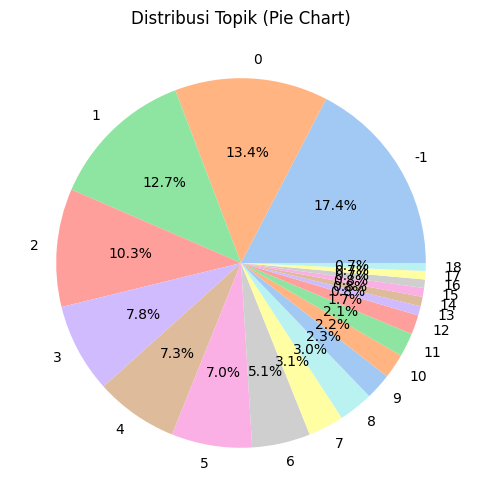

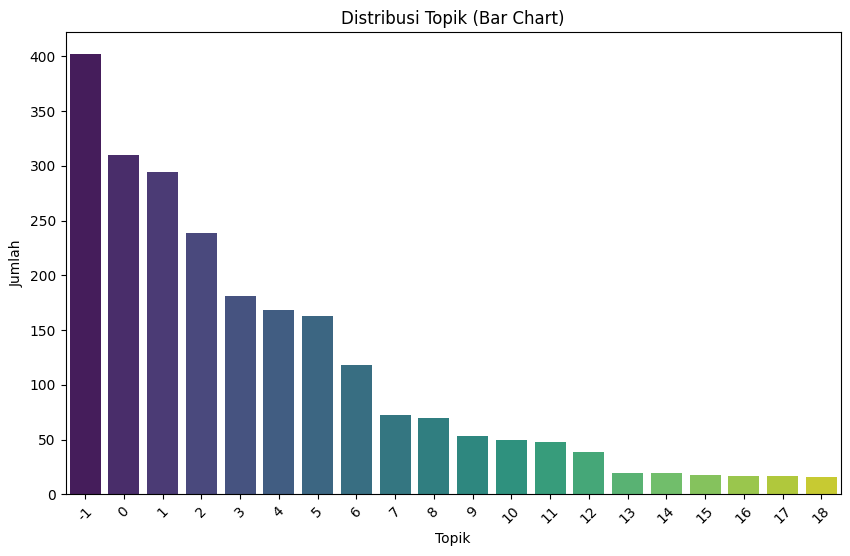

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nama file CSV
file_csv = "hasil_gabungan_2.csv"  # Ganti dengan nama file yang sesuai

# Membaca file CSV
df = pd.read_csv(file_csv)

# Menghitung jumlah tiap topik
topic_counts = df['topic'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribusi Topik (Pie Chart)")
plt.show()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel("Topik")
plt.ylabel("Jumlah")
plt.title("Distribusi Topik (Bar Chart)")
plt.xticks(rotation=45)  # Memutar label agar lebih terbaca
plt.show()


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

# **---Bagian Topic Description----**

In [ ]:
pip install joblib

In [ ]:
import pandas as pd

# Membaca file CSV
df = pd.read_csv('Hasil_1.csv')  # Ganti dengan path file Anda

# Menampilkan beberapa baris untuk melihat data
print(df.head())


                                        cleaned_text  topic
0              agus dungu berenang gaya kayu ngapung     -1
1  kesini emosi lihat sistem penegakan hukum indo...     13
2                                         agus dungu     52
3                           sih kayaknya agus goblok     43
4  ngentot mama mu dalil solat jumat rakaat dalil...      7


In [ ]:
# Memuat model dan TF-IDF vectorizer yang telah disimpan
import joblib

# Memuat model yang telah disimpan
loaded_model = joblib.load('model_logistic_regression.pkl')

# Memuat TF-IDF Vectorizer yang telah disimpan
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Fungsi untuk melakukan prediksi
# Prediksi untuk setiap baris dalam dataset
# Prediksi untuk setiap baris dalam dataset
def predict_ujaran_kebencian(text):
    # Mengonversi teks baru ke dalam representasi TF-IDF
    text_tfidf = loaded_tfidf.transform([text])

    # Menggunakan model untuk melakukan prediksi
    prediction = loaded_model.predict(text_tfidf)

    # Jika prediksi langsung menghasilkan label teks, kita langsung gunakan hasil tersebut
    predicted_label = prediction[0]  # Prediksi sudah berupa label teks, tidak perlu mapping

    return predicted_label

# Prediksi untuk setiap baris dalam dataset
df['predicted_label'] = df['cleaned_text'].apply(predict_ujaran_kebencian)
print(df.head())  # Menampilkan hasil prediksi




                                        cleaned_text  topic predicted_label
0              agus dungu berenang gaya kayu ngapung     -1          HINAAN
1  kesini emosi lihat sistem penegakan hukum indo...     13          HINAAN
2                                         agus dungu     52          HINAAN
3                           sih kayaknya agus goblok     43          HINAAN
4  ngentot mama mu dalil solat jumat rakaat dalil...      7          HINAAN


In [ ]:
# Mengelompokkan berdasarkan topik dan menghitung jenis ujaran kebencian yang paling sering
topik_summary = df.groupby('topic')['predicted_label'].agg(lambda x: x.mode()[0])  # mode() mengembalikan label yang paling sering
print(topik_summary)


topic
-1         HINAAN
 0         HINAAN
 1         HINAAN
 2         HINAAN
 3           SARA
 4        HASUTAN
 5        HASUTAN
 6         HINAAN
 7         HINAAN
 8         HINAAN
 9        HASUTAN
 10          SARA
 11        HINAAN
 12        HINAAN
 13       HASUTAN
 14       HASUTAN
 15        HINAAN
 16        HINAAN
 17        HINAAN
 18        HINAAN
 19       HASUTAN
 20        HINAAN
 21        HINAAN
 22        HINAAN
 23        HINAAN
 24       HASUTAN
 25       HASUTAN
 26        HINAAN
 27       HASUTAN
 28          SARA
 29          SARA
 30        HINAAN
 31        HINAAN
 32        HINAAN
 33        HINAAN
 34        HINAAN
 35        HINAAN
 36       HASUTAN
 37        HINAAN
 38        HINAAN
 39       HASUTAN
 40        HINAAN
 41    PENCEMARAN
 42        HINAAN
 43        HINAAN
 44        HINAAN
 45        HINAAN
 46        HINAAN
 47       HASUTAN
 48        HINAAN
 49        HINAAN
 50          SARA
 51    PENCEMARAN
 52        HINAAN
 53        HINAAN
Name

In [ ]:
# prompt: simpan topik summary pada file scv

# Save the topic summary to a CSV file
topik_summary.to_csv('topik_summary.csv')


In [ ]:
# Menyajikan distribusi jenis ujaran kebencian per topik
topik_frequencies = df.groupby('topic')['predicted_label'].value_counts().unstack(fill_value=0)
print(topik_frequencies)


predicted_label  FITNAH  HASUTAN  HINAAN  PENCEMARAN  PROFOKASI  SARA
topic                                                                
-1                    7      205     514          64          1   105
 0                    0        0     123           1          0    32
 1                    0        0      74          14          0     0
 2                    0       16      35           7          0    13
 3                    0        0      10           1          0    56
 4                    0       55       4           2          0     1
 5                    0       31      18           1          0     4
 6                    0        6      44           0          0     0
 7                    0        0      45           0          0     2
 8                    0        7      26           3          0     6
 9                    0       17      12          11          0     0
 10                   0        0      16           3          0    19
 11                 

In [ ]:
# prompt: simpan topik_frequencies ke file csv

# Save the topic frequencies to a CSV file
topik_frequencies.to_csv('topik_frequencies.csv')


In [ ]:
# Menyimpan hasil prediksi dan analisis ke dalam file CSV
df.to_csv('prediksi_ujaran_kebencian.csv', index=False)
topik_summary.to_csv('kesimpulan_per_topik.csv', header=True)

print("Hasil analisis telah disimpan.")


Hasil analisis telah disimpan.


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

# **---Bagian Perbandingan Keakuratan Data----**

In [ ]:
!pip install pandas matplotlib scikit-learn


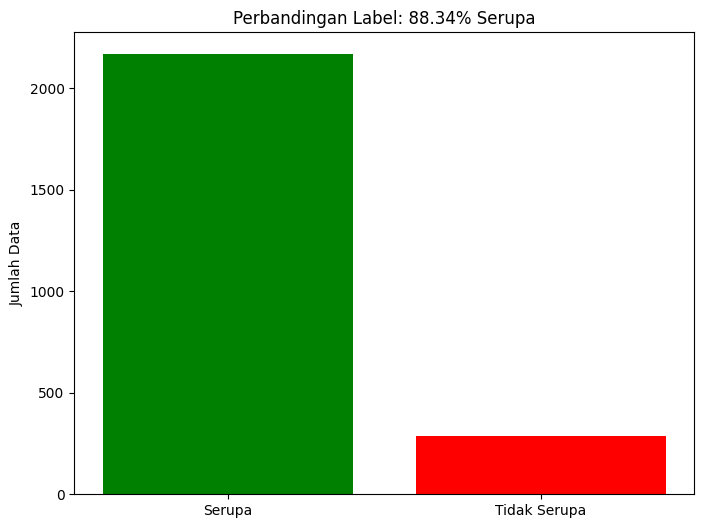

Persentase kecocokan label: 88.34%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Fungsi untuk membaca file CSV dan melakukan perbandingan
def compare_labels(file1, file2):
    # Membaca file CSV pertama
    df1 = pd.read_csv(file1)
    # Membaca file CSV kedua
    df2 = pd.read_csv(file2)

    # Memastikan kolom yang digunakan untuk perbandingan ada
    if 'predicted_label' not in df1.columns or 'label' not in df2.columns:
        print("Kolom 'label' tidak ditemukan dalam salah satu file.")
        return None

    # Memastikan kedua DataFrame memiliki jumlah baris yang sama
    if df1.shape[0] != df2.shape[0]:
        print("Jumlah baris pada kedua file CSV tidak sama.")
        return None

    # Menghitung persentase kecocokan label antara kedua file
    matching_labels = (df1['predicted_label'] == df2['label']).sum()
    total_labels = len(df1)

    # Menghitung akurasi
    accuracy = (matching_labels / total_labels) * 100

    # Membuat visualisasi perbandingan label
    plt.figure(figsize=(8, 6))
    plt.bar(['Serupa', 'Tidak Serupa'], [matching_labels, total_labels - matching_labels], color=['green', 'red'])
    plt.title(f'Perbandingan Label: {accuracy:.2f}% Serupa')
    plt.ylabel('Jumlah Data')
    plt.show()

    return accuracy

# Path file CSV Anda
file1 = 'prediksi_ujaran_kebencian.csv'  # Ganti dengan path file pertama
file2 = 'Final.csv'  # Ganti dengan path file kedua

# Panggil fungsi untuk membandingkan dan menampilkan hasil
accuracy = compare_labels(file1, file2)

if accuracy is not None:
    print(f"Persentase kecocokan label: {accuracy:.2f}%")


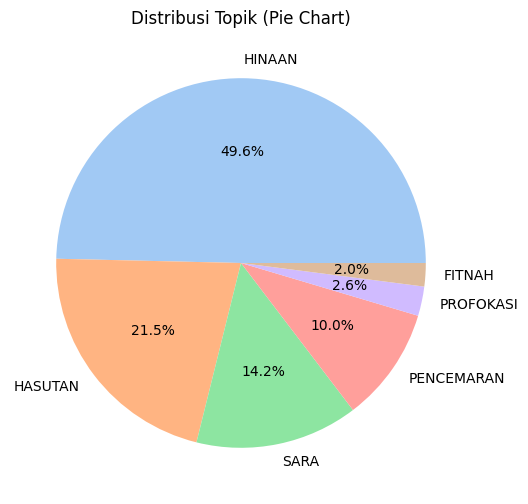

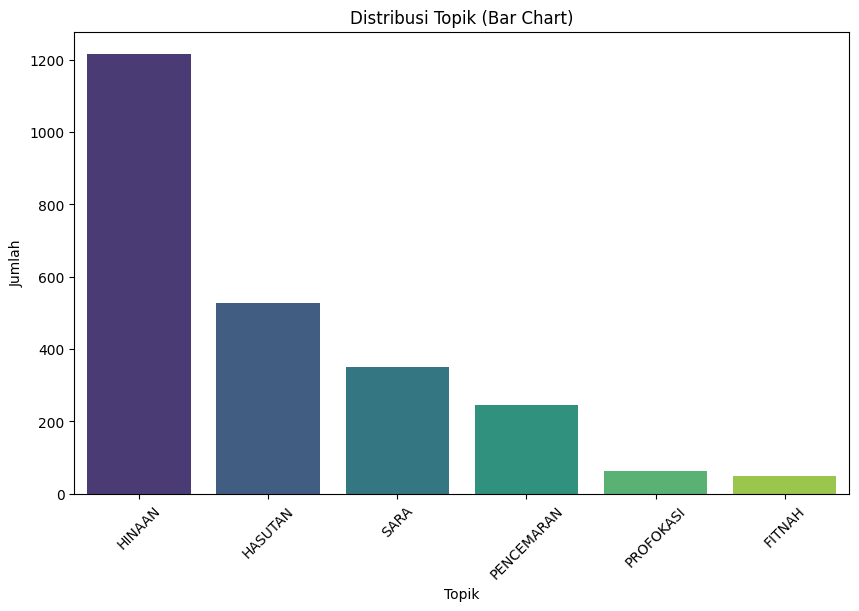

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nama file CSV
file_csv = "Final.csv"  # Ganti dengan nama file yang sesuai

# Membaca file CSV
df = pd.read_csv(file_csv)

# Menghitung jumlah tiap topik
topic_counts = df['label'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribusi Topik (Pie Chart)")
plt.show()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel("Topik")
plt.ylabel("Jumlah")
plt.title("Distribusi Topik (Bar Chart)")
plt.xticks(rotation=45)  # Memutar label agar lebih terbaca
plt.show()


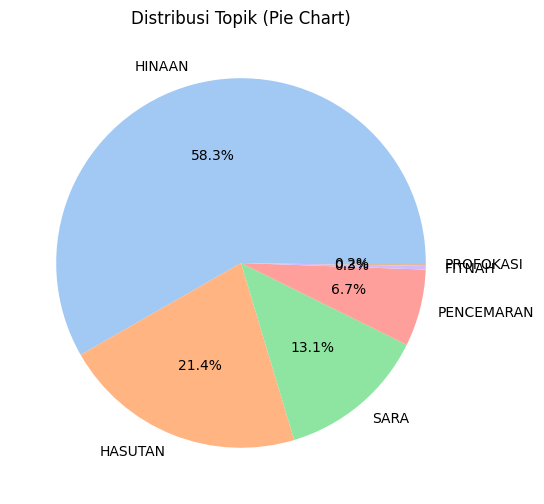

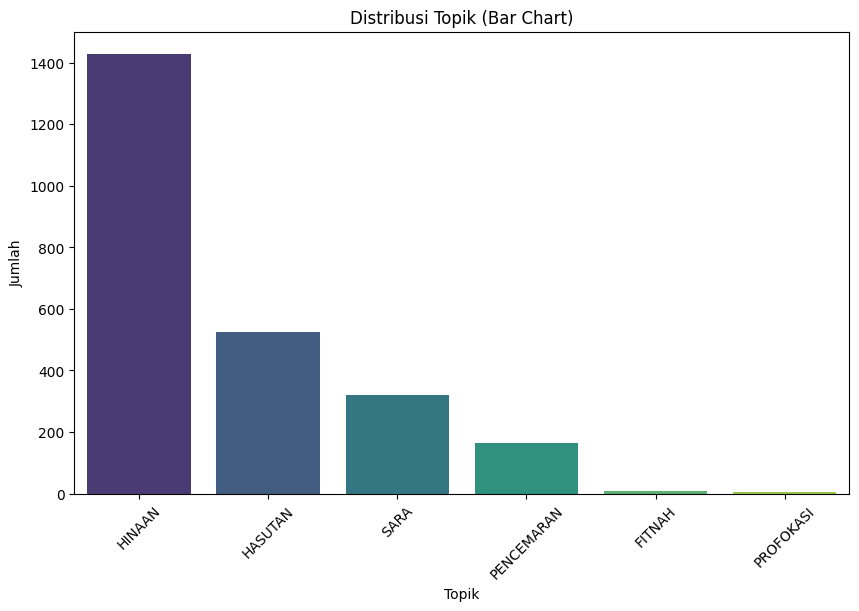

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nama file CSV
file_csv = "prediksi_ujaran_kebencian.csv"  # Ganti dengan nama file yang sesuai

# Membaca file CSV
df = pd.read_csv(file_csv)

# Menghitung jumlah tiap topik
topic_counts = df['predicted_label'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribusi Topik (Pie Chart)")
plt.show()

# Membuat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.xlabel("Topik")
plt.ylabel("Jumlah")
plt.title("Distribusi Topik (Bar Chart)")
plt.xticks(rotation=45)  # Memutar label agar lebih terbaca
plt.show()


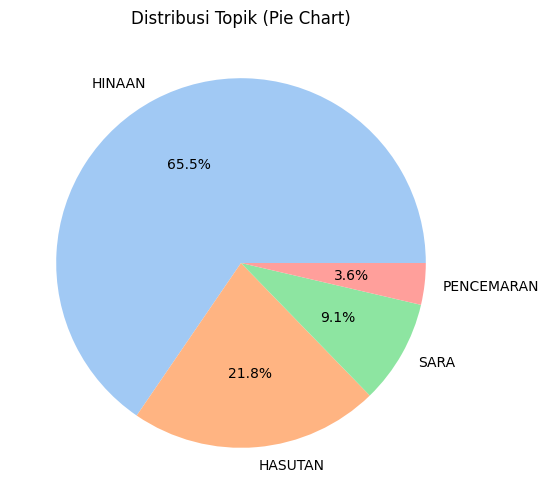

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nama file CSV
file_csv = "topik_summary.csv"  # Ganti dengan nama file yang sesuai

# Membaca file CSV
df = pd.read_csv(file_csv)

# Menghitung jumlah tiap topik
topic_counts = df['predicted_label'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 6))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Distribusi Topik (Pie Chart)")
plt.show()


In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
"""
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
######################################################################
"""

In [ ]:
import pandas as pd

# Membaca kedua file CSV
file1_path = "file1.csv"  # Ganti dengan path file pertama
file2_path = "file2.csv"  # Ganti dengan path file kedua

file1 = pd.read_csv(file1_path)
file2 = pd.read_csv(file2_path)

# Pastikan kolom 'cleaned_text' ada di kedua file dan topik ada di kedua file
# Jika tidak ada, pastikan untuk menyesuaikan nama kolom

# Gabungkan berdasarkan kolom 'cleaned_text' (misalnya teks)
merged_data = pd.merge(file1, file2, on='cleaned_text', how='left', suffixes=('_file1', '_file2'))

# Cek apakah kolom topik di file1 adalah 0, jika ya, ganti dengan topik di file2
merged_data['topic'] = merged_data.apply(
    lambda row: row['topic'] if row['topic'] == 0 else row['topic'], axis=1
)

# Pilih kolom yang diperlukan (misalnya 'cleaned_text' dan 'topic_file1')
final_data = merged_data[['cleaned_text', 'topic']]

# Simpan hasil ke file baru
output_file_path = "gabungan_file.csv"  # Ganti dengan nama file output yang diinginkan
final_data.to_csv(output_file_path, index=False)

# Opsional: Menampilkan beberapa baris pertama untuk memastikan hasilnya
print(final_data.head())


FileNotFoundError: [Errno 2] No such file or directory: 'file1.csv'

In [ ]:
# 6. Skor Probabilitas untuk Dokumen Tertentu
doc_index = 0  # Ganti dengan indeks dokumen yang ingin Anda lihat
doc_probabilities = probabilities[doc_index]
print(f"\nSkor Probabilitas untuk Dokumen {doc_index}:")
print(doc_probabilities)


Skor Probabilitas untuk Dokumen 0:
[0.01479111 0.02789384 0.01320801 0.02405704 0.01377916 0.01581058
 0.03555012 0.01737523 0.01704869 0.01491621 0.21807305 0.00955778
 0.01546008 0.02579714 0.01405644 0.0331448  0.01691119 0.01823111
 0.0234512  0.00937807 0.01794468]


In [ ]:
# 7. Dokumen yang Diassign ke Setiap Topik
assigned_topics = topic_model.get_document_info(documents)
print("\nDokumen yang Diassign ke Setiap Topik:")
print(assigned_topics)


Dokumen yang Diassign ke Setiap Topik:
                                               Document  Topic  \
0                    buntung berenang gaya kayu ngapung      0   
1     kesini emosi lihat sistem penegakan hukum indo...      0   
2                                               buntung      3   
3                                 sih kayaknya  buntung      0   
4                                          buntung wkwk      3   
...                                                 ...    ...   
1448  sekeluarga ngefans kagum lihat dehtapi lihat a...     -1   
1449  pandangan tuhan lo jelek sih gue perebut suami...      0   
1450                                   jeleklecekbantet      0   
1451  wey goblok bedain vape shisha sm rokok lo nger...      0   
1452     jablay anjir mukanya murahan bangetttt najisss      0   

                                 Name  \
0     0_korupsi_negara_presiden_orang   
1     0_korupsi_negara_presiden_orang   
2           3_buntung_wkwkwk_wkwk_gua   
3  

In [ ]:
# 9. Hierarki Topik (Jika Dihubungkan)
hierarchy = topic_model.visualize_hierarchy()
print("\nVisualisasi Hierarki Topik:")
hierarchy.show()


Visualisasi Hierarki Topik:


In [ ]:
# prompt: saya ingin membagi setiap topik menjadi beberapa kelompok berdasarkan topik utama

# Assuming 'topic_model' and 'topics' are already defined from the previous code.

# Group documents by topic
grouped_documents = {}
for i, topic in enumerate(topics):
    if topic not in grouped_documents:
        grouped_documents[topic] = []
    grouped_documents[topic].append(documents[i])

# Print the documents for each topic
for topic, docs in grouped_documents.items():
    print(f"Topic {topic}:")
    for doc in docs:
        print(f"- {doc}")
    print("-" * 20)

Topic 2:
-  buntung berenang gaya kayu ngapung
-  buntung
-  buntung
-  buntung emang gatau
-  buntung
-  buntung  buntung banget
- lord  buntung
-  buntung
- jir kek  buntung
-  buntung
- tipikal  buntung jg si bos babi
-  buntung jg borgol
-  sedih  buntung  goblok  om
- klo buntung 
- knp  buntung sii
-  buntung tuh jenis larva sih
-  buntung
-  buntung versi beda
- jijik sm muka  buntung
- gw kang bunuh  buron
- eh lu gua put bio gua tumbalin lu  buntung mampus
-  buntung moco mringis
- iclik nunggu yo guyu  buntung
--------------------
Topic 0:
- kesini emosi lihat sistem penegakan hukum indonesia aph pd becus kerja sesuai sop sih
- sih kayaknya  buntung
- terima anjing nicsap disamain kaya  caboel
- kayaknya  buntung pengen coli cari mangsa allah ngeri
-  buntung cela abis abisan netizen membela  menyudutkan polisi bilang masuk akal cape netizen reaktif
- jadiin babi guling ajangga tau terima kasih numpang hidup negeri orang
- gua meragukan  buntung tindakan pemerkosaan gua celah

In [ ]:
# prompt: lakukan perhitungan menggunakan TF-IDF untuk setiap topik

from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'grouped_documents' is defined from the previous code.

# Calculate TF-IDF for each topic
for topic, docs in grouped_documents.items():
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()

    print(f"TF-IDF for Topic {topic}:")
    for doc_idx, doc_scores in enumerate(tfidf_scores):
        print(f"Document {doc_idx + 1}:")
        for word_idx, score in enumerate(doc_scores):
            if score > 0:  # Only print words with non-zero TF-IDF score
                print(f"- {feature_names[word_idx]}: {score}")
        print("-" * 20)

Output streaming akan dipotong hingga 5000 baris terakhir.
- btw: 0.2944178076654205
- china: 0.21617542820261532
- dasar: 0.2502433167497578
- ditiup: 0.32468609180531693
- drama: 0.32468609180531693
- gada: 0.28467359661675423
- hujat: 0.3069802806223046
- menit: 0.25900618529939584
- nihatut: 0.32468609180531693
- pemain: 0.24294841511396048
- wasit: 0.21997503260986137
- yaaa: 0.2944178076654205
--------------------
Document 1097:
- ama: 0.2873643610891532
- anyink: 0.372849962740351
- arab: 0.2599576035862297
- australia: 0.3100294225234395
- cina: 0.467633721880171
- ft: 0.372849962740351
- indonesia: 0.19315228548403432
- kalah: 0.2503770257063467
- lawan: 0.20665814479181044
- seri: 0.3380916872902846
--------------------
Document 1098:
- anjirr: 0.7363687633587979
- cina: 0.4617820838104469
- kalah: 0.49448796893465097
--------------------
Document 1099:
- china: 0.4269515753338551
- giliran: 0.4942364596726419
- kalah: 0.4306221352552465
- lawan: 0.35543026093181
- ngerti: 0.

In [ ]:
# prompt: tampilkan 3 kata dengan nilai tf-idf tertinggi dari tiap dokumen yang telah di bobot

# Assuming 'grouped_documents' is defined from the previous code.

# Calculate TF-IDF for each topic and get top 3 words
for topic, docs in grouped_documents.items():
    if not docs:  # Skip empty topic lists
        continue

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()

    print(f"Top 3 TF-IDF words for Topic {topic}:")
    for doc_idx, doc_scores in enumerate(tfidf_scores):
        top_word_indices = doc_scores.argsort()[-3:][::-1]  # Get indices of top 3 words
        print(f"Document {doc_idx + 1}:")
        for word_idx in top_word_indices:
          print(f"- {feature_names[word_idx]}: {doc_scores[word_idx]}")
        print("-" * 20)

Output streaming akan dipotong hingga 5000 baris terakhir.
Document 433:
- perang: 0.4310245292488669
- krna: 0.3277383209806366
- dy: 0.3277383209806366
--------------------
Document 434:
- ciotaan: 0.2976756354873727
- alhamdulilah: 0.2976756354873727
- binatang: 0.2976756354873727
--------------------
Document 435:
- memangnya: 0.7552974861608944
- beliau: 0.6259414858512126
- korupsi: 0.1942240038960417
--------------------
Document 436:
- guan: 0.26333387892770793
- koporasi: 0.26333387892770793
- shm: 0.26333387892770793
--------------------
Document 437:
- periksa: 0.37427472008272067
- pertamina: 0.36380720325956906
- spbu: 0.36380720325956906
--------------------
Document 438:
- ngerjain: 0.5815517442817223
- nen: 0.5815517442817223
- pelaku: 0.4414102556200215
--------------------
Document 439:
- bro: 0.7426599315122062
- menang: 0.6352714651134986
- korupsi: 0.2118640878932396
--------------------
Document 440:
- sumber: 0.4303485600590176
- bergizi: 0.39907733533402917
- di

In [ ]:
# prompt: tampilkan 15 kata dengan poin tertinggi dalam 1 topik

# Assuming 'topic_model' is already defined from the previous code.
# Get the top 15 words for each topic
for topic_id in range(len(topic_model.get_topic_info())):
  if topic_id != -1:  # Exclude the outlier topic
    top_words = topic_model.get_topic(topic_id)
    if top_words:
      print(f"Top 15 words for Topic {topic_id}: {top_words[:30]}")

Top 15 words for Topic 0: [('korupsi', 0.045759774111704454), ('orang', 0.017664071856953786), ('negara', 0.01735668894331282), ('presiden', 0.016855600227086938), ('koruptor', 0.01644656556451064), ('lu', 0.014122862828563919), ('indonesia', 0.013744125570184935), ('rakyat', 0.013648394849415922), ('jaksa', 0.011820926314146388), ('agama', 0.011628699415223149)]
Top 15 words for Topic 1: [('hamas', 0.25027701824768533), ('teroris', 0.09623805019588322), ('israel', 0.0663592895039192), ('gaza', 0.05267916567975398), ('sipil', 0.050648936473363826), ('zionis', 0.041900373726242265), ('idf', 0.0378586510269119), ('korban', 0.03376595764890922), ('perang', 0.0331796447519596), ('warga', 0.0321418892688033)]
Top 15 words for Topic 2: [('buntung', 1.1217390486411927), ('gua', 0.11472328574317056), ('jg', 0.10765981085175187), ('mringis', 0.09954655605848108), ('larva', 0.09954655605848108), ('lord', 0.09954655605848108), ('jir', 0.09954655605848108), ('jenis', 0.09954655605848108), ('iclik'

In [ ]:
# prompt: berikan kategori tiap topik berdasarkan 15 kata dengan poin tertinggi berdasarkan katergori berikut
# categories = {
#     "Penghinaan": ["jijik", "jelek", "norak", "muka boros", "otak kosong", "biadab","alay", "ampas", "keparat", "anjing", "babi", "bacot", "bajingan", "banci", "bandot", "bangsat", "bego", "bejat", "bencong", "bodoh", "berengsek", "gembel", "gila", "goblok", "idiot", "jablay", "kacrut", "kampungan", "kimak", "kunyuk", "najis", "nete", "sampah", "sarap", "setan", "sompret", "sontoloyo", "terkutuk", "tolol"],
#     "Pencemaran Nama Baik": ["pelakor", "lonte", "pezina", "murahan","jancuk", "munafik", "hina", "onta", "panastak", "panasbung", "rezim", "rejim", "pasukan nasi"],
#     "Provokasi": ["sontoloyo", "sompret", "lengser", "cebong", "bani kotak"],
#     "Fitnah": ["pelakor", "pezina","kafir", "autis", "antek", "komunis", "ateis"],
#     "Hasutan": ["lgbt", "lesbi", "homo", "transgender", "gay"],
#     "Diskriminasi": ["asing", "cebong", "sipit", "gembrot", "gendut", "cungkring", "krempeng", "burik", "bisu", "cacat"],
#     "Penghinaan Agama": ["sok alim","kafir", "ateis", "setan", "iblis"],
#     "SARA": ["kafir", "lgbt", "lesbi", "homo", "transgender", "cebong", "bani kotak"]
# }

def categorize_topics(topic_words, categories):
    topic_categories = {}
    for topic_id, words in topic_words.items():
        if topic_id == -1:
            continue  # Skip the outlier topic

        max_score = 0
        max_category = None
        for category, keywords in categories.items():
            score = 0
            for word in words[:30]:  # Consider only the top 15 words
                if word in keywords:
                    score += 1
            if score > max_score:
                max_score = score
                max_category = category
        topic_categories[topic_id] = max_category if max_category else "Unknown"
    return topic_categories

# Example usage (assuming topic_model and topics_keywords are defined)
# topics_keywords = topic_model.get_topics()  # already defined in the original code
categories = {
    "Penghinaan": ["jijik", "jelek", "norak", "muka boros", "otak kosong", "biadab","alay", "ampas", "keparat", "anjing", "babi", "bacot", "bajingan", "banci", "bandot", "bangsat", "bego", "bejat", "bencong", "bodoh", "berengsek", "gembel", "gila", "goblok", "idiot", "jablay", "kacrut", "kampungan", "kimak", "kunyuk", "najis", "nete", "sampah", "sarap", "setan", "sompret", "sontoloyo", "terkutuk", "tolol"],
    "Pencemaran Nama Baik": ["pelakor", "lonte", "pezina", "murahan","jancuk", "munafik", "hina", "onta", "panastak", "panasbung", "rezim", "rejim", "pasukan nasi"],
    "Provokasi": ["sontoloyo", "sompret", "lengser", "cebong", "bani kotak"],
    "Fitnah": ["pelakor", "pezina","kafir", "autis", "antek", "komunis", "ateis"],
    "Hasutan": ["lgbt", "lesbi", "homo", "transgender", "gay"],
    "Diskriminasi": ["asing", "cebong", "sipit", "gembrot", "gendut", "cungkring", "krempeng", "burik", "bisu", "cacat"],
    "Penghinaan Agama": ["sok alim","kafir", "ateis", "setan", "iblis"],
    "SARA": ["kafir", "lgbt", "lesbi", "homo", "transgender", "cebong", "bani kotak"]
}

topic_categories = categorize_topics(topic_model.get_topics(), categories)
topic_categories

{0: 'Unknown',
 1: 'Unknown',
 2: 'Unknown',
 3: 'Unknown',
 4: 'Unknown',
 5: 'Unknown',
 6: 'Unknown',
 7: 'Unknown',
 8: 'Unknown',
 9: 'Unknown',
 10: 'Unknown'}

In [ ]:
# prompt: buat kolom topik, lalu label data dari -1 - 8, sesuai hasil distribusi topik, dan simpan ke file csv baru

# Assuming 'topics' contains the topic labels for each document
# and 'data' is your original DataFrame

# Create a new column 'topic' in the DataFrame
data['topic'] = topics

# Create a mapping for the labels
label_mapping = {}
for i in range(-1,9): # Assuming you want labels from -1 to 8
  label_mapping[i] = i

# Map the topic labels to numerical values using the mapping
data['label'] = data['topic'].map(label_mapping)


# Save the updated DataFrame to a new CSV file
new_file_path = "tahap_7_with_topics.csv"
data.to_csv(new_file_path, index=False)


In [ ]:
# prompt: setiap dokumen diatas harus dimasukan kedalam beberapa kategori berikut jika memuat kata-kata berikut
# Penghinaan : alay, ampas, keparat, anjing, babi, bacot, bajingan, banci, bandot, bangsat, bego, bejat, bencong, bodoh, berengsek, gembel, gila, goblok, idiot, jablay, kacrut, kampungan, kimak, kunyuk, najis, nete, sampah, sarap, setan, sompret, sontoloyo, terkutuk, tolol
# Pencemaran Nama Baik : jancuk, munafik, hina, onta, panastak, panasbung, rezim, rejim, pasukan nasi
# provokasi : sontoloyo, sompret, lengser, cebong, bani kotak
# fitnah : kafir, autis, antek, komunis, ateis
# hasutan : lgbt, lesbi, homo, transgender, gay
# diskriminasi : asing, cebong, sipit, gembrot, gendut, cungkring, krempeng, burik, bisu, cacat
# penghinaan agama : kafir, ateis, setan, iblis
# SARA : kafir, lgbt, lesbi, homo, transgender, cebong, bani kotak

import pandas as pd

def categorize_text(text):
    """Categorizes text based on keywords."""
    categories = set()

    penghinaan_keywords = ["jijik", "jelek", "norak", "muka boros", "otak kosong", "biadab","alay", "ampas", "keparat", "anjing", "babi", "bacot", "bajingan", "banci", "bandot", "bangsat", "bego", "bejat", "bencong", "bodoh", "berengsek", "gembel", "gila", "goblok", "idiot", "jablay", "kacrut", "kampungan", "kimak", "kunyuk", "najis", "nete", "sampah", "sarap", "setan", "sompret", "sontoloyo", "terkutuk", "tolol"]
    pencemaran_nama_baik_keywords = ["pelakor", "lonte", "pezina", "murahan","jancuk", "munafik", "hina", "onta", "panastak", "panasbung", "rezim", "rejim", "pasukan nasi"]
    provokasi_keywords = ["sontoloyo", "sompret", "lengser", "cebong", "bani kotak"]
    fitnah_keywords = ["pelakor", "pezina","kafir", "autis", "antek", "komunis", "ateis"]
    hasutan_keywords = ["lgbt", "lesbi", "homo", "transgender", "gay"]
    diskriminasi_keywords = ["asing", "cebong", "sipit", "gembrot", "gendut", "cungkring", "krempeng", "burik", "bisu", "cacat"]
    penghinaan_agama_keywords = ["sok alim","kafir", "ateis", "setan", "iblis"]
    sara_keywords = ["kafir", "lgbt", "lesbi", "homo", "transgender", "cebong", "bani kotak"]

    # Lowercase the input text for case-insensitive matching
    text_lower = text.lower()

    if any(keyword in text_lower for keyword in penghinaan_keywords):
        categories.add("Penghinaan")
    if any(keyword in text_lower for keyword in pencemaran_nama_baik_keywords):
        categories.add("Pencemaran Nama Baik")
    if any(keyword in text_lower for keyword in provokasi_keywords):
        categories.add("Provokasi")
    if any(keyword in text_lower for keyword in fitnah_keywords):
        categories.add("Fitnah")
    if any(keyword in text_lower for keyword in hasutan_keywords):
        categories.add("Hasutan")
    if any(keyword in text_lower for keyword in diskriminasi_keywords):
        categories.add("Diskriminasi")
    if any(keyword in text_lower for keyword in penghinaan_agama_keywords):
        categories.add("Penghinaan Agama")
    if any(keyword in text_lower for keyword in sara_keywords):
        categories.add("SARA")

    return list(categories)

# Example usage with your existing DataFrame
# Assuming 'data' is your DataFrame and 'cleaned_text' is the column with text data
data['categories'] = data['cleaned_text'].apply(categorize_text)

# Save the updated data to a new CSV file
data.to_csv("tahap_7_categorized.csv", index=False)
data

,cleaned_text,categories
0,agus buntung berenang gaya kayu ngapung,[Hasutan]
1,kesini emosi lihat sistem penegakan hukum indo...,[]
2,yup dev mode nextjs efeknya emang kadang lumay...,[]
3,agus buntung,[]
4,menerima sahabat duta australia indonesia bese...,[]
...,...,...
1745,heran gw mak knp pake ma anv pesbur bederet sk...,[]
1746,wey goblok bedain vape shisha sm rokok lo nger...,[Penghinaan]
1747,jijik liatnyakaya ulet bulu kluget gituhihihia...,[Penghinaan]
1748,jablay anjir mukanya murahan bangetttt najisss,"[Pencemaran Nama Baik, Penghinaan]"


In [ ]:
# prompt: saya memiliki file csv yang berisi dua kolom, teks dan kategori, bisakah anda melakukan sorting dimana teks yang memiliki kategori di letakan di bagian atas dan teks yang tidak memiliki kategori dibagian bawah

import pandas as pd

# Load the data
file_path = "tahap_7_categorized.csv"
data = pd.read_csv(file_path)

# Sort the DataFrame
data_sorted = data.sort_values(by='categories', key=lambda x: x.astype(str).str.len(), ascending=False)

# Save the sorted data to a new CSV file
data_sorted.to_csv("final_procces.csv", index=False)

In [ ]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)


In [ ]:
import openai
from bertopic.representation import OpenAI

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key="sk-...")
representation_model = OpenAI(client, model="gpt-3.5-turbo", chat=True)
topic_model = BERTopic(representation_model=representation_model)
